# Neural Networks Homework 
***
**Name**: Saikrishna Jaliparthy 
***

This assignment is due on Moodle by **11:59pm on Wednesday May 2nd**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 

In [1]:
import pickle, gzip
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

### [30 points] Problem 1: Building and Training a Feed-Forward Neural Network 
***

In this problem you'll implement a general feed-forward neural network class that utilizes sigmoid activation functions. Your tasks will be to implement `forward propagation`, `prediction`, `back propagation`, `gradient_checking`, and a general `train` routine to learn the weights in your network via Stochastic Gradient Descent.  

The skeleton for the `Network` class is below. Note that this class is almost identical to the one you worked with in the **Lecture 18** in-class notebook, so you should look there to remind yourself of the details.   Scroll down to find more information about your tasks as well as unit tests. 

**Important Note**: In **Problem 2** we'll be using the `Network` class to train a network to do handwritten digit recognition.  Please make sure to utilize vectorized Numpy routines as much as possible, as writing inefficient code here will cause very slow training times in **Problem 2**. 

In [2]:
class Network:
    def __init__(self, sizes):
        """
        Initialize the neural network 
        
        :param sizes: a list of the number of neurons in each layer 
        """
        # save the number of layers in the network 
        self.L = len(sizes) 
        
        # store the list of layer sizes 
        self.sizes = sizes  
        
        # initialize the bias vectors for each hidden and output layer 
        self.b = [np.random.randn(n) for n in self.sizes[1:]]
        
        # initialize the matrices of weights for each hidden and output layer 
        self.W = [np.random.randn(n, m) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the derivatives of biases for backprop 
        self.db = [np.zeros(n) for n in self.sizes[1:]]
        
        # initialize the derivatives of weights for backprop 
        self.dW = [np.zeros((n, m)) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the activities on each hidden and output layer 
        self.z = [np.zeros(n) for n in self.sizes]
        
        # initialize the activations on each hidden and output layer 
        self.a = [np.zeros(n) for n in self.sizes]
        
        # initialize the deltas on each hidden and output layer 
        self.delta = [np.zeros(n) for n in self.sizes]
        
        self.tr_acc=[]
        self.va_acc=[]
        self.ep=[]
        
    def g(self, z):
        """
        sigmoid activation function 
        
        :param z: vector of activities to apply activation to 
        """
        z = np.clip(z, -20, 20)
        return 1.0/(1.0 + np.exp(-z))
    
    def g_prime(self, z):
        """
        derivative of sigmoid activation function 
        
        :param z: vector of activities to apply derivative of activation to 
        """
        return self.g(z) * (1.0 - self.g(z))
    
    def C(self, a, y):
        """
        evaluate the cost function for squared-loss C(a,y) = ||a-y||^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        return 0.5 * np.linalg.norm(a - y)**2
    
    def gradC(self, a, y):
        """
        evaluate gradient of cost function for squared-loss C(a,y) = ||a-y||^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        return (a - y)
    
    def forward_prop(self, x):
        """
        take an feature vector and propagate through network 
        
        :param x: input feature vector 
        """
        # TODO: Initialize activation on initial layer to x 
        
        # TODO: Loop over layers and compute activities and activations 
        self.a[0]=x
        for i in range(self.L-1):
            mul=np.dot(self.W[i],self.a[i])
            self.z[i+1]=np.add(mul,self.b[i])
            self.a[i+1]=self.g(self.z[i+1])   
        
    def predict(self, X):
        """
        Predicts on the the data in X. Assume at least two output neurons so predictions
        are one-hot encoded vectorized labels. 
        
        :param X: a matrix of data to make predictions on 
        :return y: a matrix of vectorized labels 
        """
        
        yhat = np.zeros((X.shape[0], self.sizes[-1]), dtype=int)
        # TODO: Populate yhat with one-hot-coded predictions
        
        for i in range(X.shape[0]):
            self.forward_prop(X[i])
            for j in range(self.sizes[-1]):
                if(self.a[self.L-1][j]>0.5):
                    yhat[i][j]=1
        return yhat 
    
    def accuracy(self, X, y):
        """
        compute accuracy on labeled training set 

        :param X: matrix of features 
        :param y: matrix of vectorized true labels 
        """
        yhat = self.predict(X)
        return np.sum(np.all(np.equal(yhat, y), axis=1)) / X.shape[0]
            
            
    def back_prop(self, x, y):
        """
        Back propagation to get derivatives of C wrt weights and biases for given training example
        
        :param x: training features  
        :param y: vector-encoded label 
        """
        # TODO: forward prop training example to fill in activities and activations 
        self.forward_prop(x)
        
        # TODO: compute deltas on output layer
        self.delta[self.L-1]=np.multiply(self.gradC(self.a[self.L-1], y),self.g_prime(self.z[self.L-1]))
        
        # TODO: loop backward through layers, backprop deltas, compute dWs and dbs
        for ll in range(self.L-2, -1, -1):
            
            lend=len(self.delta[ll+1])
            lena=len(self.a[ll])
            db=np.reshape(self.delta[ll+1],(lend,1))
            ab=np.reshape((((self.a[ll])[np.newaxis]).T),(1,lena))
            self.dW[ll]=np.multiply(db,ab)
            self.db[ll]=self.delta[ll+1]
            self.delta[ll]=np.multiply(np.dot(np.transpose(self.W[ll]),self.delta[ll+1]),self.g_prime(self.z[ll]))
        
        
    def gradient_checking(self, X_train, y_train, EPS=0.0001):
        """
        Performs gradient checking on all weights in the 
        network for a randomly selected training example 
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        """
        # Randomly select a training example 
        kk = np.random.randint(0,X_train.shape[0])
        xk = X_train[kk]
        yk = y_train[kk]

        # Get the analytic(ish) weights from back_prop 
        self.back_prop(xk, yk)

        # List of relative errors.  Used only for unit testing. 
        rel_errors = []

        # Loop over and perturb each weight/bias in 
        # network and test numerical derivative 
        # Don't forget that after perturbing the weights
        # you'll want to put them back the way they were! 
        
        # Loop over and perturb each weight/bias in 
        # network and test numerical derivative 
        for ell in range(self.L-1):
            for ii in range(self.W[ell].shape[0]):
                # Check weights in level W[ell][ii,jj] 
                for jj in range(self.W[ell].shape[1]):
                    
                    # TODO true_dW
                    true_dW=self.dW[ell][ii,jj] 
                    # TODO num_dW 
                    x=self.W[ell][ii,jj]
                    
                    self.W[ell][ii,jj]=self.W[ell][ii,jj]+EPS
                    self.forward_prop(xk)
                    addc=self.C(self.a[-1],yk)
                    
                    self.W[ell][ii,jj]=x
                    
                    
                    self.W[ell][ii,jj]=self.W[ell][ii,jj]-EPS
                    self.forward_prop(xk)
                    subc=self.C(self.a[-1],yk)
                    
                    self.W[ell][ii,jj]=x
                    
                    num_dW=(addc-subc)/(2*EPS)
                    
                    rel_dW = np.abs(true_dW-num_dW)/np.abs(true_dW)
                    print("W[{:d}][{:d},{:d}]: true: {: 12.10e}  approx: {: 12.10e} rel_err: {: 12.10e}".format(ell, ii, jj, true_dW, num_dW, rel_dW))
                    rel_errors.append(rel_dW)
                    
                # Check bias b[ell][ii]
                
                # TODO 
                true_db=self.db[ell][ii]  
                # TODO
                y=self.b[ell][ii]
                self.b[ell][ii]=self.b[ell][ii]+EPS
                self.forward_prop(xk)
                addbc=self.C(self.a[-1],yk)
                self.b[ell][ii]=y
                
                    
                self.b[ell][ii]=self.b[ell][ii]-EPS
                self.forward_prop(xk)
                subbc=self.C(self.a[-1],yk)
                self.b[ell][ii]=y
                
                num_db=(addbc-subbc)/(2*EPS)  
                
                rel_db = np.abs(true_db-num_db)/np.abs(true_db)
                print("b[{:d}][{:d}]:   true: {: 12.10e}  approx: {: 12.10e} rel_err: {: 12.10e}".format(ell, ii, true_db, num_db, rel_db))
                rel_errors.append(rel_db)

        return rel_errors
            
            
    def train(self, X_train, y_train, X_valid=None, y_valid=None, eta=0.25, lam=0.0, num_epochs=10, isPrint=True):
        """
        Train the network with SGD 
        
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        :param X_train: optional matrix of validation features 
        :param y_train: optional matrix of vector-encoded validation labels 
        :param eta: learning rate 
        :param lam: regularization strength 
        :param num_epochs: number of epochs to run 
        :param isPrint: flag indicating to print training progress or not 
        """
        
        # initialize shuffled indices 
        shuffled_inds = list(range(X_train.shape[0]))
        
        # loop over training epochs 
        for ep in range(num_epochs):
            
            # shuffle indices 
            np.random.shuffle(shuffled_inds)

            # loop over training examples 
            for ind in shuffled_inds:
                xk=X_train[ind]
                yk=y_train[ind]
                # TODO: back prop to get derivatives 
                self.back_prop(xk, yk)
                
                # TODO: update weights and biases
                self.W=[W - (eta*dW)-(eta*lam*W) for (W, dW) in zip(self.W, self.dW)]
                self.b =[b - (eta*db) for (b, db) in zip(self.b, self.db)]
                
            # occasionally print accuracy
            if isPrint and ((ep+1)%5)==1:
                self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
                
                self.tr_acc.append(self.accuracy(X_train, y_train))
                self.va_acc.append(self.accuracy(X_valid, y_valid))
                self.ep.append(ep+1)
                
        # print final accuracy
        if isPrint:
            self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
                
                    
    def epoch_report(self, ep, num_epochs, X_train, y_train, X_valid, y_valid):
        """
        Print the accuracy for the given epoch on training and validation data 
        
        :param ep: the current epoch 
        :param num_epochs: the total number of epochs
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        :param X_train: optional matrix of validation features 
        :param y_train: optional matrix of vector-encoded validation labels 
        """
        
        print("epoch {:3d}/{:3d}: ".format(ep+1, num_epochs), end="")
        print("  train acc: {:8.3f}".format(self.accuracy(X_train, y_train)), end="")
        
        if X_valid is not None: 
            print("  valid acc: {:8.3f}".format(self.accuracy(X_valid, y_valid)))
        else: 
            print("")
    
        
    

**Part A**: Complete the `forward_prop` function in the `Network` class to implement forward propagation.  Your function should take in a single training example `x` and propagate it forward in the network, setting the activations and activities on the hidden and output layers.  When you think you're done, execute the following unit test. 

In [3]:
%run -i nn_tests.py "prob 1A"

testForwardProp (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


**Part B**: Complete the `predict` function in the `Network` class to take in a matrix of features and return a matrix of one-hot-encoded label predictions. Your one-hot-encoded predictions should correspond to the output neuron with the largest activation.   

When you think your `predict` function is working well, execute the following unit test. 

In [4]:
%run -i nn_tests.py "prob 1B"

testPredict (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


**Part C**: OK, now it's time to implement back propagation.  Complete the function ``back_prop`` in the ``Network`` class to use a single training example to compute the derivatives of the loss function with respect to the weights and the biases. As in the **Lecture 18** in-class notebook, you may assume that the loss function for a single training example is given by 

$$
C(y, {\bf a}^L) = \frac{1}{2}\|y - {\bf a}^L\|^2  
$$

When you think you're done, execute the following unit test. 

In [5]:
%run -i nn_tests.py "prob 1C"

testBackProp (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


**Part D**: Due to the fact that we hard-code our various activation functions, cost functions, and their derivatives, it is vital to do some debugging to make sure we haven't made a mistake.  

One common technique is to do **numerical gradient checking**.  In this method we compute numerical approximations of the derivatives of the cost function with respect to the model parameters and compare them to the analytic versions computed by back prop.  

Consider a cost function $C$ which is a function of all of the weights and biases in the network.  We can estimate the derivative of $C$ with respect to a particular parameter using a numerical finite difference technique.  This process looks as follows 

$$
\frac{\partial C}{\partial w_i} \approx \frac{C(w_1,\ldots, w_i+\epsilon, \ldots w_N) - C(w_1,\ldots, w_i-\epsilon, \ldots w_N)}{2\epsilon}
$$

Evaluating the cost function with the perturbed weights can be accomplished by randomly choosing a training example, performing forward propagation, and then evaluating the cost function using the activations in the output layer.  

I've given you starter code down below to do numerical gradient checking.  The code will compute the true and numerical values of the derivative of $C$ with respect to each parameter in the network and then plot the pairs of values as well as their relative errors.  Note that in practice this is extremely expensive, and we typically only check a few random parameters. 

When you believe your code is correct, you can test it by executing the following cell. Note that a good rule of thumb is to train the network for a handful of epochs before doing the gradient checking, to avoid any transient behavior that might occur at the very beginning of the training process. 

In [6]:
%run -i nn_tests.py "prob 1D"

testGradCheck (__main__.TestNN) ... 

W[0][0,0]: true: -1.6129176665e-02  approx: -1.6129176655e-02 rel_err:  6.2758809415e-10
W[0][0,1]: true: -3.2258353331e-02  approx: -3.2258353251e-02 rel_err:  2.4817827221e-09
b[0][0]:   true: -1.6129176665e-02  approx: -1.6129176655e-02 rel_err:  6.2758809415e-10
W[0][1,0]: true:  1.0259238746e-02  approx:  1.0259238739e-02 rel_err:  6.6307893984e-10
W[0][1,1]: true:  2.0518477492e-02  approx:  2.0518477439e-02 rel_err:  2.5974560468e-09
b[0][1]:   true:  1.0259238746e-02  approx:  1.0259238739e-02 rel_err:  6.6307893984e-10
W[0][2,0]: true: -5.1903568015e-04  approx: -5.1903567999e-04 rel_err:  3.0985203531e-10
W[0][2,1]: true: -1.0380713603e-03  approx: -1.0380713582e-03 rel_err:  2.0477984656e-09
b[0][2]:   true: -5.1903568015e-04  approx: -5.1903567999e-04 rel_err:  3.0985203531e-10
W[1][0,0]: true: -7.1372985374e-02  approx: -7.1372985357e-02 rel_err:  2.3383240182e-10
W[1][0,1]: true: -4.3055527018e-02  approx: -4.3055527015e-02 rel_err:  8.6212384741e-11
W[1][0,2]: true: -7.8

ok

----------------------------------------------------------------------
Ran 1 test in 0.013s

OK


**Part E**: OK, now let's actually train a neural net!  Complete the missing code in ``train`` to loop over the training data in random order, call `back_prop` to get the derivatives, and then update the weights and the biases via SGD.  When you think you're done, execute the following code

In [73]:
%run -i nn_tests.py "prob 1E"

testSGD (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


**Part F**: Last but not least, we should implement $\ell$-$2$ regularization.  Modify your `train` function to incorporate regularization of the weights (but **not** the biases) in your SGD update.  As in the Lecture 18 slides, you should assume that the cost function with regularization takes the form 

$$
C_\lambda = C + \frac{\lambda}{2} \displaystyle\sum_{w} w^2
$$

where $\sum_{w}$ sums over each weight in all layers of the network. Think carefully before you go making large changes to your code.  This modification is much simpler than you think. When you think you're done, execute the following unit test.  (Then go back and execute the test in **Part C** to make sure you didn't break anything.) 

In [74]:
%run -i nn_tests.py "prob 1F"

testRegularizedSGD (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


### [20 points] Problem 2: A Neural Network Classifier for Handwritten Digit Recognition 
***

In this problem you'll use the Feed-Forward Neural Network framework you wrote in **Problem 1** to take an image of a handwritten digit and predict which digit it corresponds to.  

![Samples of Handwritten Digits](mnist.png "MNIST Digits")

To keep run times down we'll again only consider the subset of the MNIST data set consisting of the digits $3, 7, 8$ and $9$. 

**Part A**: Executing the following cells will load training and validation data and plot an example handwritten digit.  Explore the training and validation sets and answer the following questions: 

- How many pixels are in each image in the data set?  
- How do the true labels correspond to the associated one-hot-encoded label vectors? 
- Give an example of a network architecture with a single hidden layer that is compatible with this data. 


In [53]:
X_train, y_train, X_valid, y_valid = pickle.load(gzip.open("../data/mnist21x21_3789_one_hot.pklz", "rb"))

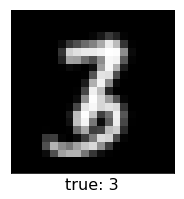

In [54]:
def view_digit(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(21,21), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)
        
training_index = 2
label_dict = dict({0:3, 1:7, 2:8, 3:9})
view_digit(X_train[training_index], label_dict[np.argmax(y_train[training_index])])

In [55]:
print("The Number of pixels are in each image in the data set are: ",len(X_train[0]))

The Number of pixels are in each image in the data set are:  441


In [56]:
lab=[2,7,5,3]

for la in lab:
    print(y_train[la],"Represents the number:",label_dict[np.argmax(y_train[la])])

[1 0 0 0] Represents the number: 3
[0 1 0 0] Represents the number: 7
[0 0 1 0] Represents the number: 8
[0 0 0 1] Represents the number: 9


In [57]:
print("The example of a network architecture with a single hidden layer that is compatible with this data is: ",[441,100,4])

print("The architecture's input layer has 441 neurons")
print("The architecture has one hidden layer with 100 neurons")
print("The architecture's output layer has 4 neurons")

The example of a network architecture with a single hidden layer that is compatible with this data is:  [441, 100, 4]
The architecture's input layer has 441 neurons
The architecture has one hidden layer with 100 neurons
The architecture's output layer has 4 neurons


**Part B**: Train a network with a single hidden layer containing $30$ neurons on the first $500$ training examples in the training set using a learning rate of $\eta = 0.01$ for at least $50$ epochs.  What accuracy does your network achieve on the validation set?  Do you see any clear signs of overfitting?   

In [16]:
nnb = Network([441,30,4])
nnb.train(X_train[0:500], y_train[0:500], X_valid, y_valid, eta=0.01, num_epochs=50, isPrint=True)

epoch   1/ 50:   train acc:    0.000  valid acc:    0.000
epoch   6/ 50:   train acc:    0.192  valid acc:    0.161
epoch  11/ 50:   train acc:    0.362  valid acc:    0.325
epoch  16/ 50:   train acc:    0.476  valid acc:    0.464
epoch  21/ 50:   train acc:    0.562  valid acc:    0.553
epoch  26/ 50:   train acc:    0.628  valid acc:    0.608
epoch  31/ 50:   train acc:    0.670  valid acc:    0.643
epoch  36/ 50:   train acc:    0.708  valid acc:    0.679
epoch  41/ 50:   train acc:    0.742  valid acc:    0.695
epoch  46/ 50:   train acc:    0.764  valid acc:    0.724
epoch  50/ 50:   train acc:    0.780  valid acc:    0.734


The accuracy the network achieve on the validation set was 0.734 at epoch 50.

I don't see any clear signs of overfitting as the validation accuracy.

**Part C**: Modify the `Network` class so that it stores the accuracies on the training and validation data every $5$ epochs during the training process. Now increase the number of neurons in the hidden layer to $100$.  On a single set of axes, plot the **validation accuracy** vs epoch for networks trained on the full training set for at least 50 epochs using the learning rates $\eta = 0.01$, $\eta = 0.25$ and $\eta = 1.5$.  Which learning rate seems to perform the best? What is the best accuracy achieved on the validation set?   

epoch   1/ 50:   train acc:    0.346  valid acc:    0.341
epoch   6/ 50:   train acc:    0.635  valid acc:    0.612
epoch  11/ 50:   train acc:    0.809  valid acc:    0.783
epoch  16/ 50:   train acc:    0.849  valid acc:    0.821
epoch  21/ 50:   train acc:    0.874  valid acc:    0.851
epoch  26/ 50:   train acc:    0.889  valid acc:    0.861
epoch  31/ 50:   train acc:    0.904  valid acc:    0.867
epoch  36/ 50:   train acc:    0.910  valid acc:    0.873
epoch  41/ 50:   train acc:    0.915  valid acc:    0.881
epoch  46/ 50:   train acc:    0.923  valid acc:    0.885
epoch  50/ 50:   train acc:    0.925  valid acc:    0.888
epoch   1/ 50:   train acc:    0.606  valid acc:    0.592
epoch   6/ 50:   train acc:    0.947  valid acc:    0.894
epoch  11/ 50:   train acc:    0.977  valid acc:    0.917
epoch  16/ 50:   train acc:    0.984  valid acc:    0.920
epoch  21/ 50:   train acc:    0.987  valid acc:    0.923
epoch  26/ 50:   train acc:    0.989  valid acc:    0.923
epoch  31/ 50:

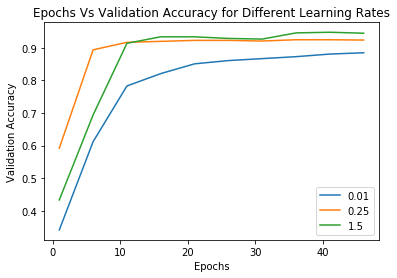

In [18]:
eps=[0.01,0.25,1.5]
for e in eps:
    nnc = Network([441,100,4])
    nnc.train(X_train, y_train, X_valid, y_valid, eta=e, num_epochs=50, isPrint=True)
    plt.plot(nnc.ep,nnc.va_acc,label=str(e))

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Epochs Vs Validation Accuracy for Different Learning Rates")
plt.show()

Based on the above graph learning rate 1.5 seems to be perform best.

The best accuracy acheived on the validation set is 0.948 (at epoch 41/50) 

**Part D**:  Now let's see if we can get better results with regularization. Using the best learning rate you found in **Part C**, on a single set of axes, plot the **validation accuracy** vs epoch for networks trained on the full training set for at least 50 epochs using the regularization strengths $\lambda = 10^{-6}$, $\lambda = 10^{-4}$ and $\lambda = 10^{-2}$.  Which regularization strength seems to perform the best? What is the best accuracy achieved on the validation set?   

epoch   1/ 50:   train acc:    0.833  valid acc:    0.821
epoch   6/ 50:   train acc:    0.952  valid acc:    0.912
epoch  11/ 50:   train acc:    0.961  valid acc:    0.928
epoch  16/ 50:   train acc:    0.977  valid acc:    0.943
epoch  21/ 50:   train acc:    0.968  valid acc:    0.918
epoch  26/ 50:   train acc:    0.980  valid acc:    0.938
epoch  31/ 50:   train acc:    0.964  valid acc:    0.920
epoch  36/ 50:   train acc:    0.988  valid acc:    0.946
epoch  41/ 50:   train acc:    0.989  valid acc:    0.951
epoch  46/ 50:   train acc:    0.992  valid acc:    0.957
epoch  50/ 50:   train acc:    0.994  valid acc:    0.949
epoch   1/ 50:   train acc:    0.807  valid acc:    0.806
epoch   6/ 50:   train acc:    0.939  valid acc:    0.920
epoch  11/ 50:   train acc:    0.949  valid acc:    0.927
epoch  16/ 50:   train acc:    0.815  valid acc:    0.798
epoch  21/ 50:   train acc:    0.956  valid acc:    0.947
epoch  26/ 50:   train acc:    0.956  valid acc:    0.924
epoch  31/ 50:

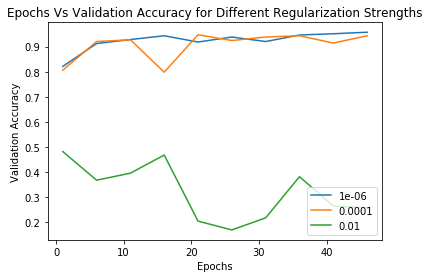

In [43]:
lam=[0.000001,0.0001,0.01]
for l in lam:
    nnc = Network([441,100,4])
    nnc.train(X_train, y_train, X_valid, y_valid, eta=1.5, lam=l, num_epochs=50, isPrint=True)
    plt.plot(nnc.ep,nnc.va_acc,label=str(l))

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Epochs Vs Validation Accuracy for Different Regularization Strengths")
plt.show()

The regularization strength $\lambda = 10^{-6}$ (0.000001) is perfoming the best

The best Accuracy acheived on the validation set is 0.957 at epoch (46/50)

**Part E**:  Now let's see if we can get better results with different network architectures. On a single set of axes, plot the **validation accuracy** vs epoch for networks trained on the full training set for at least 50 epochs using the architecture from **Part D** as well as two other architectures.  Which architecture seems to perform the best? What is the best accuracy achieved on the validation set?   

epoch   1/ 50:   train acc:    0.869  valid acc:    0.853
epoch   6/ 50:   train acc:    0.946  valid acc:    0.928
epoch  11/ 50:   train acc:    0.942  valid acc:    0.911
epoch  16/ 50:   train acc:    0.954  valid acc:    0.921
epoch  21/ 50:   train acc:    0.951  valid acc:    0.918
epoch  26/ 50:   train acc:    0.952  valid acc:    0.908
epoch  31/ 50:   train acc:    0.966  valid acc:    0.924
epoch  36/ 50:   train acc:    0.958  valid acc:    0.917
epoch  41/ 50:   train acc:    0.970  valid acc:    0.929
epoch  46/ 50:   train acc:    0.986  valid acc:    0.955
epoch  50/ 50:   train acc:    0.983  valid acc:    0.935
epoch   1/ 50:   train acc:    0.818  valid acc:    0.815
epoch   6/ 50:   train acc:    0.922  valid acc:    0.906
epoch  11/ 50:   train acc:    0.929  valid acc:    0.912
epoch  16/ 50:   train acc:    0.952  valid acc:    0.924
epoch  21/ 50:   train acc:    0.944  valid acc:    0.928
epoch  26/ 50:   train acc:    0.944  valid acc:    0.922
epoch  31/ 50:

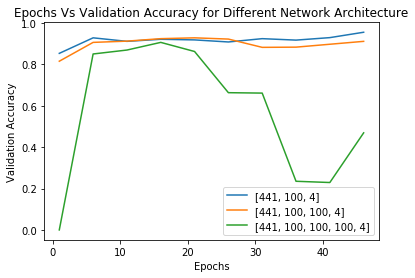

In [59]:
arc=[[441,100,4],[441,100,100,4],[441,100,100,100,4]]
for a in arc:
    nnc = Network(a)
    nnc.train(X_train, y_train, X_valid, y_valid, eta=1.5, lam=0.000001, num_epochs=50, isPrint=True)
    plt.plot(nnc.ep,nnc.va_acc,label=str(a))

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Epochs Vs Validation Accuracy for Different Network Architecture")
plt.show()

Architecture with single hidden layer with 100 neurons ([441,100,4]) is performing the best.

The Best Accuracy achieved on the validation set is 0.955 at epoch (46/50)

### [max 20 points] Extra Credit: Improving Network Performance 
***

See if you can get better performance by exploring advanced techniques.  Things you might try are: 

- Implementing **Mini-Batch** Stochastic Gradient Descent 
- Experimenting with different activation functions (like tanh and **Leaky** ReLU)
- Experimenting with different loss functions (like cross-entropy) 

For more detailed discussion of these techniques it'll be helpful to look at Chapter 3 of [Nielsen](http://neuralnetworksanddeeplearning.com/chap3.html). 

The amount of extra credit you receive will be proportional to the number of above suggested tasks that you complete.  Further, to receive credit for the tasks you must not only implement, but also provide evidence that you've tuned the network to make it work.  Comment on the performance differences between the original `Network` implementation and your new networks with bells and whistles. 

**Important Note**: Don't do any of these things in the original `Network` class, because you'll almost certainly break the unit tests.  Copy the `Network` class from above and rename it `BetterNetwork` (or something) and modify the new class. 
